# Trasfer learning model

In [1]:
# !pip install seaborn

In [2]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import classification_report

## Dataset

In [3]:
dataset_path = os.path.join('../../Brain Tumor Data Set')
dataset = tf.keras.utils.image_dataset_from_directory(dataset_path)

dataset

Found 4600 files belonging to 2 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [4]:
class_names = np.array(dataset.class_names)
print(class_names)

['Brain Tumor' 'Healthy']


### Train - test split

In [5]:
ds_train = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=404,
    batch_size=128
)

Found 4600 files belonging to 2 classes.
Using 3680 files for training.


In [6]:
ds_val = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=404,
    batch_size=128
)

Found 4600 files belonging to 2 classes.
Using 920 files for validation.


In [7]:
for image_batch, labels_batch in ds_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 256, 256, 3)
(128,)


## Mobilenet_v2 - simple model

In [8]:
input_shape = (224, 224, 3)

In [9]:
resizer = lambda x, y: (tf.image.resize(x, input_shape[:2]), y)

ds_train_reshaped = ds_train.map(resizer)
ds_val_reshaped = ds_val.map(resizer)

In [10]:
for image_batch, labels_batch in ds_train_reshaped:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 224, 224, 3)
(128,)


In [11]:
base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_1 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1)
    ],
    name='mobilenet_simple'
)

model_1.summary()

Model: "mobilenet_simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
model_1.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [13]:
epochs = 30
patience = 2

In [14]:
history_1 = model_1.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/30
29/29 [==============================] - 312s 10s/step - loss: 0.6038 - binary_accuracy: 0.6291 - val_loss: 0.4959 - val_binary_accuracy: 0.6804
Epoch 2/30
29/29 [==============================] - 280s 9s/step - loss: 0.4290 - binary_accuracy: 0.7943 - val_loss: 0.3982 - val_binary_accuracy: 0.7924
Epoch 3/30
29/29 [==============================] - 284s 10s/step - loss: 0.3637 - binary_accuracy: 0.8386 - val_loss: 0.3551 - val_binary_accuracy: 0.8348
Epoch 4/30
29/29 [==============================] - 278s 9s/step - loss: 0.3301 - binary_accuracy: 0.8611 - val_loss: 0.3289 - val_binary_accuracy: 0.8543
Epoch 5/30
29/29 [==============================] - 266s 9s/step - loss: 0.3088 - binary_accuracy: 0.8734 - val_loss: 0.3122 - val_binary_accuracy: 0.8652
Epoch 6/30
29/29 [==============================] - 265s 9s/step - loss: 0.2938 - binary_accuracy: 0.8807 - val_loss: 0.2988 - val_binary_accuracy: 0.8750
Epoch 7/30
29/29 [==============================] - 269s 9s/step - l

In [15]:
history_1.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

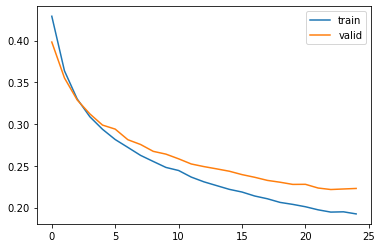

In [16]:
plt.plot(history_1.history['loss'][1:])
plt.plot(history_1.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

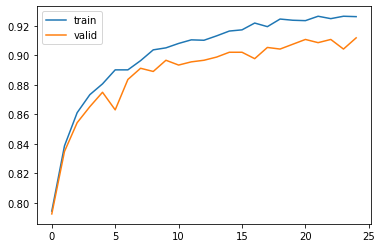

In [17]:
plt.plot(history_1.history['binary_accuracy'][1:])
plt.plot(history_1.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [18]:
x_val_1, y_val_1 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_1 = model_1.predict(x_val_1)
sum((y_pred_1[:, 0] > 0) == y_val_1) / len(y_val_1)

0.8671875

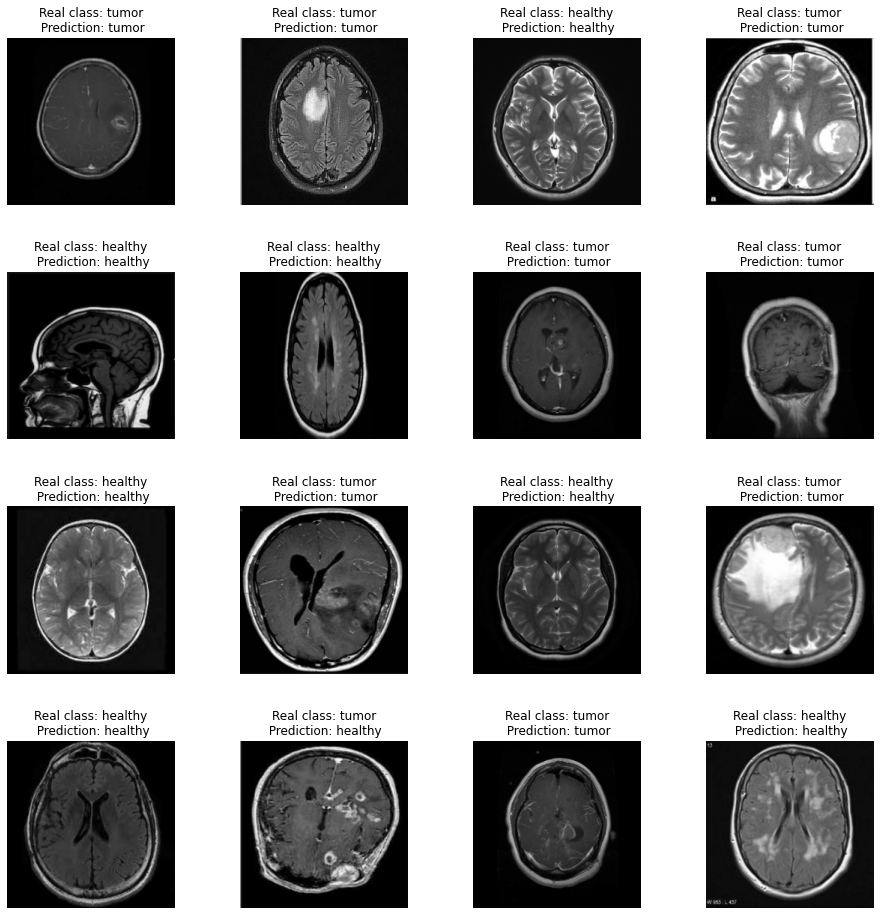

In [19]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_1[i].astype('int32'))
    
    real_y = 'healthy' if y_val_1[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_1[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')
plt.show();

In [20]:
y_pred_1_binary = [1 if y > 0 else 0 for y in y_pred_1]

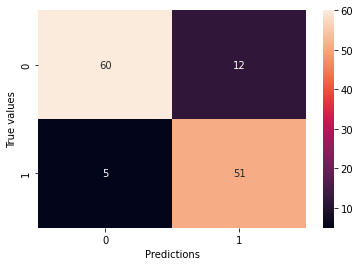

In [21]:
cf = tf.math.confusion_matrix(y_val_1, y_pred_1_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [22]:
print(classification_report(y_val_1, y_pred_1_binary, target_names=class_names))

              precision    recall  f1-score   support

 Brain Tumor       0.92      0.83      0.88        72
     Healthy       0.81      0.91      0.86        56

    accuracy                           0.87       128
   macro avg       0.87      0.87      0.87       128
weighted avg       0.87      0.87      0.87       128



## Mobilenet_v2 - model with data augmentation

In [23]:
input_shape = (224, 224, 3)

In [ ]:
base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_2 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        keras.layers.RandomContrast((0.1, 0.6), seed=404),
        keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1)
    ],
    name='mobilenet_with_augmentation'
)

model_2.summary()

In [ ]:
model_2.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [ ]:
epochs = 30
patience = 2

In [ ]:
history_2 = model_2.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

In [ ]:
history_2.history.keys()

In [ ]:
plt.plot(history_2.history['loss'][1:])
plt.plot(history_2.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

In [ ]:
plt.plot(history_2.history['binary_accuracy'][1:])
plt.plot(history_2.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [ ]:
x_val_2, y_val_2 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_2 = model_2.predict(x_val_2)
sum((y_pred_2[:, 0] > 0) == y_val_2) / len(y_val_2)

In [ ]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_2[i].astype('int32'))
    
    real_y = 'healthy' if y_val_2[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_2[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [ ]:
y_pred_2_binary = [1 if y > 0 else 0 for y in y_pred_2]

In [ ]:
cf = tf.math.confusion_matrix(y_val_2, y_pred_2_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [ ]:
print(classification_report(y_val_2, y_pred_2_binary, target_names=class_names))

## Mobilenet_v2 - model with data augmentation + additional dense layer

In [ ]:
input_shape = (224, 224, 3)

In [ ]:
base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_3 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        keras.layers.RandomContrast((0.1, 0.6), seed=404),
        keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(320),
        keras.layers.Dropout(0.25, seed=404),
        keras.layers.Dense(1)
    ],
    name='mobilenet_with_additional_dense'
)

model_3.summary()

In [ ]:
model_3.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [ ]:
epochs = 30
patience = 2

In [ ]:
history_3 = model_3.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

#### Patience increase

In [ ]:
epochs = 30
patience = 5

In [ ]:
history_3 = model_3.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

In [ ]:
history_3.history.keys()

In [ ]:
plt.plot(history_3.history['loss'][1:])
plt.plot(history_3.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

In [ ]:
plt.plot(history_3.history['binary_accuracy'][1:])
plt.plot(history_3.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [ ]:
x_val_3, y_val_3 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_3 = model_3.predict(x_val_3)
sum((y_pred_3[:, 0] > 0) == y_val_3) / len(y_val_3)

In [ ]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_3[i].astype('int32'))
    
    real_y = 'healthy' if y_val_3[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_3[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [ ]:
y_pred_3_binary = [1 if y > 0 else 0 for y in y_pred_3]

In [ ]:
cf = tf.math.confusion_matrix(y_val_3, y_pred_3_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [ ]:
print(classification_report(y_val_3, y_pred_3_binary, target_names=class_names))

## Inception_v3 - simple model

In [ ]:
input_shape = (256, 256, 3)

In [ ]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_4 = tf.keras.Sequential(
    [
        base_model,
#         keras.layers.Flatten(),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1)
    ],
    name='simple_inception'
)

model_4.summary()

In [ ]:
model_4.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [ ]:
epochs = 30
patience = 5

In [ ]:
history_4 = model_4.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

In [ ]:
history_4.history.keys()

In [ ]:
plt.plot(history_4.history['loss'][1:])
plt.plot(history_4.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

In [ ]:
plt.plot(history_4.history['binary_accuracy'][1:])
plt.plot(history_4.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [ ]:
x_val_4, y_val_4 = list(tfds.as_numpy(ds_val))[0]
y_pred_4 = model_4.predict(x_val_4)
sum((y_pred_4[:, 0] > 0) == y_val_4) / len(y_val_4)

In [ ]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_4[i].astype('int32'))
    
    real_y = 'healthy' if y_val_4[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_4[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [ ]:
y_pred_4_binary = [1 if y > 0 else 0 for y in y_pred_4]

In [ ]:
cf = tf.math.confusion_matrix(y_val_4, y_pred_4_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [ ]:
print(classification_report(y_val_4, y_pred_4_binary, target_names=class_names))

## Inception_v3 model - with data augmentation

In [ ]:
input_shape = (256, 256, 3)

In [ ]:
base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_5 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        keras.layers.RandomContrast((0.1, 0.6), seed=404),
        keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1)
    ],
    name='inception_with_augmentation'
)

model_5.summary()

In [ ]:
model_5.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [ ]:
epochs = 30
patience = 5

In [ ]:
history_5 = model_5.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

In [ ]:
history_5.history.keys()

In [ ]:
plt.plot(history_5.history['loss'][1:])
plt.plot(history_5.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

In [ ]:
plt.plot(history_5.history['binary_accuracy'][1:])
plt.plot(history_5.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [ ]:
x_val_5, y_val_5 = list(tfds.as_numpy(ds_val))[0]
y_pred_5 = model_5.predict(x_val_5)
sum((y_pred_5[:, 0] > 0) == y_val_5) / len(y_val_5)

In [ ]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_5[i].astype('int32'))
    
    real_y = 'healthy' if y_val_5[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_5[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [ ]:
y_pred_5_binary = [1 if y > 0 else 0 for y in y_pred_5]

In [ ]:
cf = tf.math.confusion_matrix(y_val_5, y_pred_5_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [ ]:
print(classification_report(y_val_5, y_pred_5_binary, target_names=class_names))

## Inception_v3 - model with data augmentation + additional dense layer

In [ ]:
input_shape = (256, 256, 3)

In [ ]:
base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_6 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        keras.layers.RandomContrast((0.1, 0.6), seed=404),
        keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(320),
        keras.layers.Dropout(0.25, seed=404),
        keras.layers.Dense(1)
    ],
    name='inception_with_additional_dense'
)

model_6.summary()

In [ ]:
model_6.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [ ]:
epochs = 30
patience = 5

In [ ]:
history_6 = model_6.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

In [ ]:
history_6.history.keys()

In [ ]:
plt.plot(history_6.history['loss'][1:])
plt.plot(history_6.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

In [ ]:
plt.plot(history_6.history['binary_accuracy'][1:])
plt.plot(history_6.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [ ]:
x_val_6, y_val_6 = list(tfds.as_numpy(ds_val))[0]
y_pred_6 = model_6.predict(x_val_6)
sum((y_pred_6[:, 0] > 0) == y_val_6) / len(y_val_6)

In [ ]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_6[i].astype('int32'))
    
    real_y = 'healthy' if y_val_6[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_6[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [ ]:
y_pred_6_binary = [1 if y > 0 else 0 for y in y_pred_6]

In [ ]:
cf = tf.math.confusion_matrix(y_val_6, y_pred_6_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [ ]:
print(classification_report(y_val_6, y_pred_6_binary, target_names=class_names))